In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde

In [2]:
# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === Optional: print shapes for quick verification ===
print(f"Combined shape: {df_combined.shape}")

Combined shape: (159, 62)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)

# === STEP 3A: StandardScaler (for classical ML)
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

df_train_std = pd.concat([ids_train.reset_index(drop=True), y_train.reset_index(drop=True), 
                          pd.DataFrame(X_train_std, columns=X.columns)], axis=1)

df_test_std = pd.concat([ids_test.reset_index(drop=True), y_test.reset_index(drop=True), 
                         pd.DataFrame(X_test_std, columns=X.columns)], axis=1)

# === STEP 3B: MinMaxScaler (for neural networks)
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

df_train_mm = pd.concat([ids_train.reset_index(drop=True), y_train.reset_index(drop=True), 
                         pd.DataFrame(X_train_mm, columns=X.columns)], axis=1)

df_test_mm = pd.concat([ids_test.reset_index(drop=True), y_test.reset_index(drop=True), 
                        pd.DataFrame(X_test_mm, columns=X.columns)], axis=1)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# === SETUP ===
X_train_fs = df_train_std.drop(columns=['Subject_ID', 'Label'])  # feature selection on train only
y_train_fs = df_train_std['Label']
feature_names = X_train_fs.columns

# === 1. SelectKBest: ANOVA F-test ===
skb_anova = SelectKBest(score_func=f_classif, k='all')
skb_anova.fit(X_train_fs, y_train_fs)
anova_scores = skb_anova.scores_

# === 2. SelectKBest: Mutual Info ===
skb_mi = SelectKBest(score_func=mutual_info_classif, k='all')
skb_mi.fit(X_train_fs, y_train_fs)
mi_scores = skb_mi.scores_

# === 3. Recursive Feature Elimination (RFE) ===
rfe_model = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=10)
rfe_model.fit(X_train_fs, y_train_fs)
rfe_ranks = ~rfe_model.support_  # False = selected → 0

# === 4. Random Forest Feature Importances ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_fs, y_train_fs)
rf_scores = rf.feature_importances_

# === Create Comparison Table ===
scores_df = pd.DataFrame({
    'Feature': feature_names,
    'ANOVA_F': anova_scores,
    'Mutual_Info': mi_scores,
    'RF_Importance': rf_scores,
    'RFE_Rank': rfe_ranks.astype(int)
}).sort_values(by='RF_Importance', ascending=False).reset_index(drop=True)

# === Top Features ===
top_anova = scores_df.nlargest(20, 'ANOVA_F')['Feature'].tolist()
top_mi = scores_df.nlargest(20, 'Mutual_Info')['Feature'].tolist()
top_rf = scores_df.nlargest(20, 'RF_Importance')['Feature'].tolist()
top_rfe = scores_df[scores_df['RFE_Rank'] == 0]['Feature'].tolist()

# === Output ===
print("🔥 Top 20 Features by ANOVA:\n", top_anova)
print("\n🔍 Top 20 Features by Mutual Info:\n", top_mi)
print("\n🌲 Top 20 Features by Random Forest:\n", top_rf)
print("\n🧹 Top Features selected by RFE:\n", top_rfe)


🔥 Top 20 Features by ANOVA:
 ['Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_precuneus_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SCAP_cingulum_ant_mid_pos_to_precuneus_R_L', 'SST_Go_precuneus_R_L_to_SMA_R_L', 'SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L', 'SST_Stop_Precentral_MFG_R_L_to_precuneus_R_L', 'SST_Stop_Middle_frontal_R_L_to_precuneus_R_L', 'SST_Go_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SST_Stop_precuneus_R_L_to_SMA_R_L', 'SCAP_precuneus_R_L_to_SMA_R_L', 'SCAP_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SCAP_occipital_sup_R_L_to_Precentral_MFG_R_L', 'SCAP_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Go_Middle_frontal_R_L_to_SMA_R_L', 'Rest_cingulum_ant_mid_pos_to_precuneus_R_L', 'SCAP_Precentral_MFG_R_L_to_SMA_R_L', 'Rest_occipital_sup_R_L_to_SMA_R_L', 'SCAP_occipital_sup_R_L_to_SMA_R_L']

🔍 Top 20 Features by Mutual Info:
 ['SST_Go_Precentral_MFG_R_L_to_SMA_R_L', 'SST_Stop_ci


🔝 Top 20 Features by Importance:
                                              Feature  Importance
52       SST_Stop_Middle_frontal_R_L_to_precuneus_R_L    0.038164
1      Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L    0.037119
18         SCAP_cingulum_ant_mid_pos_to_precuneus_R_L    0.031665
46  SST_Stop_cingulum_ant_mid_pos_to_occipital_sup...    0.031449
49           SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L    0.030704
33       SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L    0.028256
48     SST_Stop_cingulum_ant_mid_pos_to_precuneus_R_L    0.026641
57       SST_Stop_Precentral_MFG_R_L_to_precuneus_R_L    0.022600
11                  Rest_occipital_sup_R_L_to_SMA_R_L    0.022013
44                    SST_Go_precuneus_R_L_to_SMA_R_L    0.021845
16     SCAP_cingulum_ant_mid_pos_to_occipital_sup_R_L    0.021076
43               SST_Go_Precentral_MFG_R_L_to_SMA_R_L    0.020277
10            Rest_occipital_sup_R_L_to_precuneus_R_L    0.020193
50   SST_Stop_Middle_frontal_R_L_to_occipi

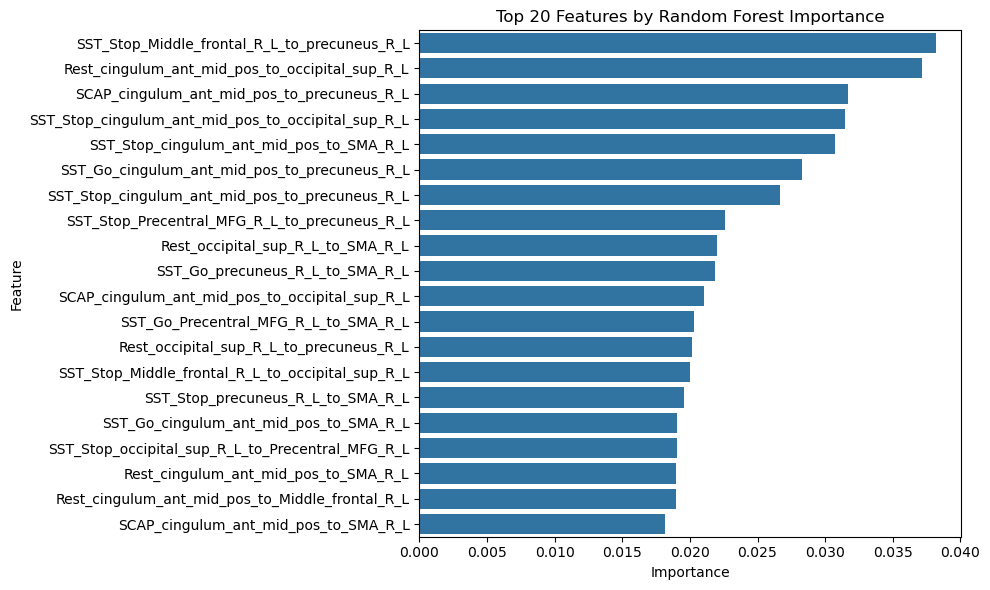

In [5]:
# Fit Random Forest separately to extract top 20 features
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X_train_std, y_train)

# Get importances and feature names
importances = rf_full.feature_importances_
feat_names = X.columns  # assuming you have original column names in X

# Create DataFrame
feature_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
top_features = feature_df.sort_values(by='Importance', ascending=False).head(20)
print("\n🔝 Top 20 Features by Importance:")
print(top_features)

# Optional: Barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature')
plt.title("Top 20 Features by Random Forest Importance")
plt.tight_layout()
plt.show()


Fitting 10 folds for each of 16 candidates, totalling 160 fits
✅ Best Params (KNN): {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}

📘 Train Classification Report
              precision    recall  f1-score   support

           0       0.86      0.98      0.92        96
           1       0.89      0.52      0.65        31

    accuracy                           0.87       127
   macro avg       0.88      0.75      0.79       127
weighted avg       0.87      0.87      0.85       127

ROC AUC: 0.9203629032258064


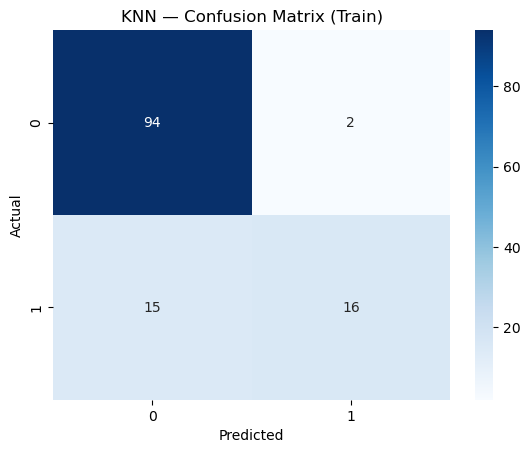

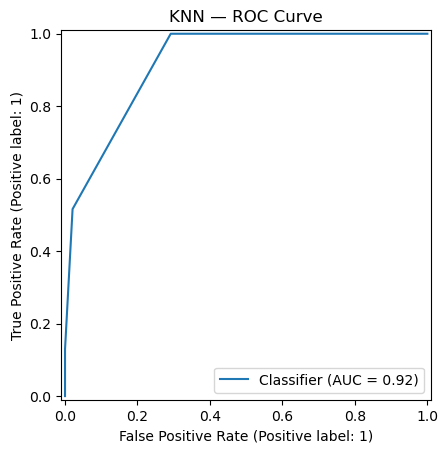

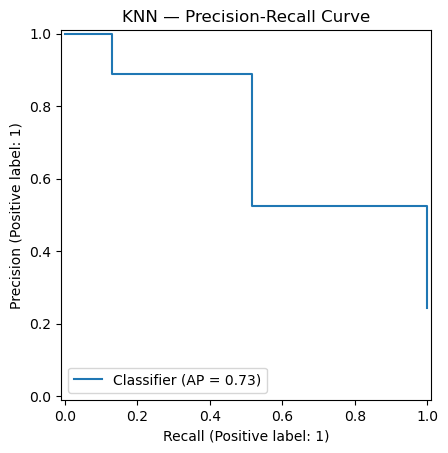

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Cross-Validated Scores:
fit_time: 0.2271
score_time: 0.0379
test_accuracy: 0.7558
train_accuracy: 0.8557
test_precision: 0.3667
train_precision: 0.8525
test_recall: 0.2250
train_recall: 0.4992
test_f1: 0.2700
train_f1: 0.6213
test_roc_auc: 0.5771
train_roc_auc: 0.9168
Feature 52: Importance = 0.0382
Feature 1: Importance = 0.0371
Feature 18: Importance = 0.0317
Feature 46: Importance = 0.0314
Feature 49: Importance = 0.0307
Feature 33: Importance = 0.0283
Feature 48: Importance = 0.0266
Feature 57: Importance = 0.0226
Feature 11: Importance = 0.0220
Feature 44: Importance = 0.0218
Feature 16: Importance = 0.0211
Feature 43: Importance = 0.0203
Feature 10: Importance = 0.0202
Feature 50: Importance = 0.0200
Feature 59: Importance = 0.0196
Feature 34: Importance = 0.0190
Feature 54: Importance = 0.0190
Feature 4: Importance = 0.0190
Feature 0: Importance = 0.0190
Feature 19: Importance = 0.0182


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector: Top 20 from Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
feature_selector = SelectFromModel(rf_selector, max_features=20, threshold=-np.inf)

# === KNN Model ===
knn = KNeighborsClassifier()

# === Pipeline ===
pipeline = Pipeline([
    ('select', feature_selector),
    ('knn', knn)
])

# === Hyperparameter Grid ===
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # Manhattan vs Euclidean
}

# === Grid Search with multiple metrics ===
grid_knn = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    },
    refit='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# === Fit Grid Search ===
grid_knn.fit(X_train_std, y_train)

# === Predict on Training Set ===
y_pred = grid_knn.predict(X_train_std)
y_proba = grid_knn.predict_proba(X_train_std)[:, 1]

# === Print Best Params & Metrics ===
print("✅ Best Params (KNN):", grid_knn.best_params_)
print("\n📘 Train Classification Report")
print(classification_report(y_train, y_pred))
print("ROC AUC:", roc_auc_score(y_train, y_proba))

# === Confusion Matrix ===
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, cmap='Blues')
plt.title("KNN — Confusion Matrix (Train)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === ROC & PR Curves ===
RocCurveDisplay.from_predictions(y_train, y_proba)
plt.title("KNN — ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_proba)
plt.title("KNN — Precision-Recall Curve")
plt.show()

# === Cross-Validation Metrics ===
cv_results = cross_validate(
    grid_knn.best_estimator_,
    X_train_std, y_train,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_results.items():
    print(f"{k}: {np.mean(v):.4f}")

# === Top 20 Features Selected by Random Forest ===
rf_selector.fit(X_train_std, y_train)
importances = rf_selector.feature_importances_
top_20_idx = np.argsort(importances)[::-1][:20]
for i in top_20_idx:
    print(f"Feature {i}: Importance = {importances[i]:.4f}")
